# Latest coverage for data sources in OpenSAFELY

This notebook provides information about data import dates and recent activity in the OpenSAFELY-TPP database. 

This notebook can be used to:

* Obtain the most recent import date for each data source
* Obtain the frequency of historical import dates for each external data source
* Obtain the most recent event date for each data source amongst TPP patients
* Understand event activity amongst TPP patients from 1 February 2020 onwards
* Estimate the latest reliable date for events recorded in each data source, i.e., a cut-off beyond which the data may be incomplete.

This notebook can not be used to:

* Obtain future import dates
* Understand patient activity over time at a national level
* Estimate the earliest reliable date for events recorded in each data source


### Data sources
Data sources are listed below, with the table name in the database given in brackets:

* Positive or negative SARS-CoV2 test, first tests only, from SGSS (`SGSS_Positive` and `SGSS_Negative`)
* Positive or negative SARS-CoV2 test, any test, from SGSS (`SGSS_AllTests_Positive` and `SGSS_AllTests_Negative`)
* A&E attendance, from SUS Emergency Care Data (`EC`)
* Hospital admission, from SUS Admitted Patient Care Data (`APCS`)
* Covid-related ICU admission, from ICNARC (`ICNARC`)
* Covid-related in-hospital death, from CPNS (`CPNS`)
* All-cause registered deaths, from ONS (`ONS_Deaths`)

For primary care data in SystmOne (`S1`), the delay from events occurring in reality to being available in OpenSAFELY is 2 - 9 days.
Reducing this to one day is possible for urgent queries where necessary.

Note that currently only the `SGSS_Negative` and `SGSS_Positive` tables are queriable with a study definition. 
These tables only provide the first known test for any person (with a few unexplained exceptions), so there won't be multiple positive tests per patient in SGSS data. Data for negative test results is unreliable. 
Support for `SGSS_AllTests_Positive` and `SGSS_AllTests_Negative` will be added later. 

Additional data sources include:
* High cost drugs (`HighCostDrugs`)
* Unique Property Reference Number, used for deriving household variables (`UPRN`)
* Master Patient Index (`MPI`)

In [23]:
## Import libraries

%load_ext autoreload
%autoreload 2

import pyodbc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as patches
import matplotlib.dates as mdates
from contextlib import contextmanager
from datetime import date, datetime
from IPython.display import display, Markdown

import sys
sys.path.append('../lib/')
from functions import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
# get server credentials from environment variable

dbconn = os.environ.get('FULL_DATABASE_URL', None).strip('"')

In [25]:
## Import libraries

with closing_connection(dbconn) as cnxn:
    DBbuild = pd.read_sql("""select * from LatestBuildTime""", cnxn)
    latestbuilds = pd.read_sql(
    """
        select BuildDesc as dataset, max(BuildDate) as latest_import from BuildInfo
        group by BuildDesc
    """, cnxn)
    allbuilds = pd.read_sql("""select * from BuildInfo""", cnxn)

# select start and end dates
start_date = pd.to_datetime("2020-02-01", format='%Y-%m-%d')
#start_date = pd.to_datetime("2020-02-01", format='%Y-%m-%d')
end_date = pd.to_datetime(latestbuilds['latest_import'].max(), format='%Y-%m-%d')
run_date = date.today()
run_datetime = datetime.now()

### Notebook run date

In [26]:
display(Markdown(f"""This notebook was run on {run_date.strftime('%Y-%m-%d')}.  The information below reflects the state of the OpenSAFELY-TPP as at this date."""))

This notebook was run on 2021-06-08.  The information below reflects the state of the OpenSAFELY-TPP as at this date.

## Latest dataset import dates
TPP create a snapshot of the primary care information captured in the SystmOne database which is processed (for example unstructured free-text is removed and other OpensAFELY-specific tables are created) before being imported into the OpenSAFELY-TPP database. 
TPP also receive (or "ingest") external datasets from SUS, ONS, etc., which are processed and imported into OpenSAFELY-TPP. 
Each imported dataset over-writes previously-imported data.

Once a dataset has been imported, it can be queried immediately in the secure environment. 
SystmOne data is imported approximately weekly. 
External datasets are imported shortly after they have been received (usually within a few days). Each external dataset is sent at different times.

The dates in the table below reflect when the datasets were last imported into the OpenSAFELY-TPP database.
They do not reflect when the data were received by TPP nor when the latest events described in each dataset occurred.

In [27]:
latestbuilds

,dataset,latest_import
0,APCS,2021-05-13 09:56:24.247
1,CPNS,2021-05-27 14:44:14.893
2,EC,2021-05-27 15:16:53.500
3,ECDS,2020-04-21 14:48:09.543
4,HealthCareWorker,2021-05-27 15:17:04.980
5,HighCostDrugs,2020-11-27 14:15:31.460
6,ICNARC,2021-01-21 11:21:12.623
7,MPI,2020-08-05 11:26:13.247
8,ONS_CIS,2021-04-28 14:59:47.487
9,ONS_Deaths,2021-05-28 11:43:31.977


The figure below shows all dataset import dates for SystmOne (`S1`) data and for external datasets, up until the date this notebook was run (the vertical black line).

Text(0.5, 1.0, 'Latest dataset import dates as at 2021-06-08')

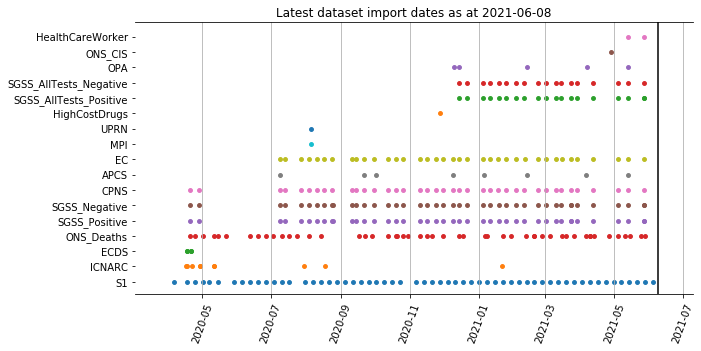

In [28]:
fig, ax = plt.subplots(figsize=(10,5))

sources = allbuilds['BuildDesc'].unique()

for source in allbuilds['BuildDesc'].unique():
    dat = allbuilds[(allbuilds['BuildDesc']==source)]
    x = dat['BuildDate']
    y = dat['BuildDesc']
    ax.scatter(x, y, marker='.', s=60)

ax.xaxis.set_tick_params(labelrotation=70)
ax.grid(True, axis='x')
ax.spines["left"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.axvline(run_datetime, color='black')
ax.set_title(f"""Latest dataset import dates as at {run_date.strftime('%Y-%m-%d')}""")

## Event activity in external datasets

Event activity (i.e., counts of patient events such as hospital admissions and deaths) is reported for each external dataset from 1 February up to the notebook run date, and for the latest 30 days of activity. 

The OpenSAFELY-TPP database only includes patients recently (< 5 years) or actively registered at a GP practice using TPP's SystmOne clinical information system (roughly 40% of English residents). 
Event activity therefore reflects these patients only.

All recorded events are extracted.

In [29]:
# Make a dataframe with consecutive dates
date_range = pd.DataFrame(
    index = pd.date_range(start=start_date, end=end_date, freq="D")
)

In [30]:
def datequery(table, var_table, var_df, from_date):
    query = (
      "SELECT " + var_table + " AS " + var_df
    + " FROM " + table
    + " WHERE " + var_table + " >= CONVERT(date, '" + from_date + "')"
    )
    return query

start_date_text = start_date.strftime('%Y-%m-%d')
#CodedEvent_query = datequery("CodedEvent", "ConsultationDate", "consultation_date", start_date_text)
#Appointment_query = datequery("Appointment", "SeenDate", "appointment_date", start_date_text)
APCS_query = datequery("APCS", "Admission_Date", "hosp_admission_date", start_date_text)
CPNS_query = datequery("CPNS", "DateOfDeath", "cpns_death_date", start_date_text)
EC_query = datequery("EC", "Arrival_Date", "ed_attendance_date", start_date_text)
ICNARC_query = datequery("ICNARC", "CONVERT(date, IcuAdmissionDateTime)", "icu_admission_date", start_date_text)
ONS_query = datequery("ONS_Deaths", "dod", "ons_death_date", start_date_text)
SGSS_query = datequery("""( 
         SELECT Earliest_Specimen_Date FROM SGSS_Positive 
         UNION ALL
         SELECT Earliest_Specimen_Date FROM SGSS_Negative
         )  AS a""", 
        "Earliest_Specimen_Date", "specimen_date", start_date_text)
SGSSpos_query = datequery("SGSS_Positive", "Earliest_Specimen_Date", "specimen_date", start_date_text)
SGSS_AllTests_query = datequery("""( 
         SELECT Specimen_Date FROM SGSS_AllTests_Positive 
         UNION ALL
         SELECT Specimen_Date FROM SGSS_AllTests_Negative
         )  AS a""", 
        "Specimen_Date", "specimen_date", start_date_text)
SGSSpos_AllTests_query = datequery("SGSS_AllTests_Positive", "Specimen_Date", "specimen_date", start_date_text)

with closing_connection(dbconn) as cnxn:
    #CodedEvent_df = pd.read_sql(CodedEvent_query, cnxn, parse_dates=['coded_event_date'])
    #Appointment_df = pd.read_sql(Appointment_query, cnxn, parse_dates=['appointment_date'])
    APCS_df = pd.read_sql(APCS_query, cnxn, parse_dates=['hosp_admission_date'])
    CPNS_df = pd.read_sql(CPNS_query, cnxn, parse_dates=['cpns_death_date'])
    EC_df = pd.read_sql(EC_query, cnxn, parse_dates=['ed_attendance_date'])
    ICNARC_df = pd.read_sql(ICNARC_query, cnxn, parse_dates=['icu_admission_date'])
    ONS_df = pd.read_sql(ONS_query, cnxn, parse_dates=['ons_death_date'])
    SGSS_df = pd.read_sql(SGSS_query, cnxn, parse_dates=['specimen_date'])
    SGSSpos_df = pd.read_sql(SGSSpos_query, cnxn, parse_dates=['specimen_date'])
    SGSS_all_df = pd.read_sql(SGSS_AllTests_query, cnxn, parse_dates=['specimen_date'])
    SGSSpos_all_df = pd.read_sql(SGSSpos_AllTests_query, cnxn, parse_dates=['specimen_date'])
    
# Note that CodedEvent and Appointment extracts take a long time to run.

The plots below show activity for 1 Feb 2020 onwards (left plot) and for the last 30 days up to the most recent event date (right plot). 
Counts less than five are redacted. 


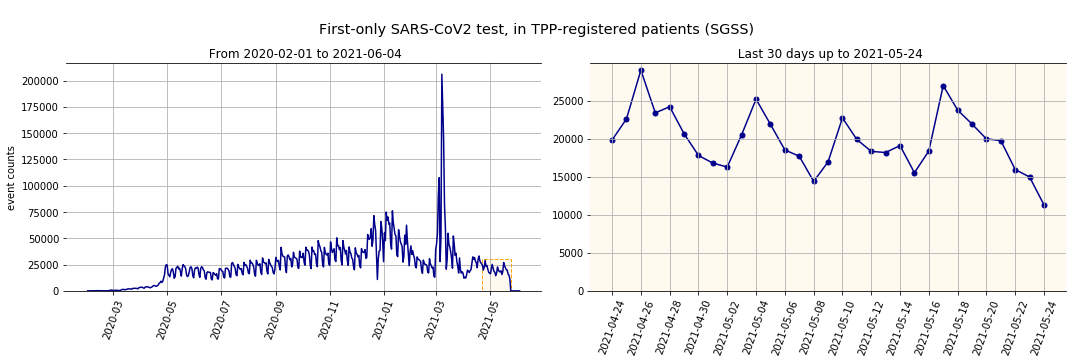

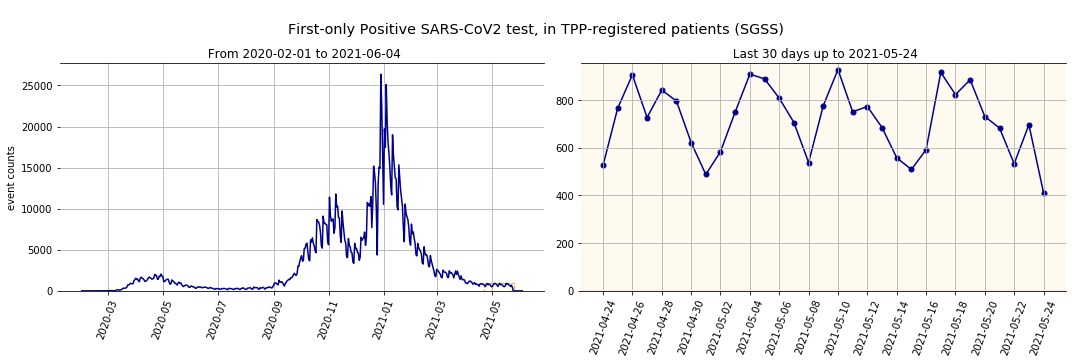

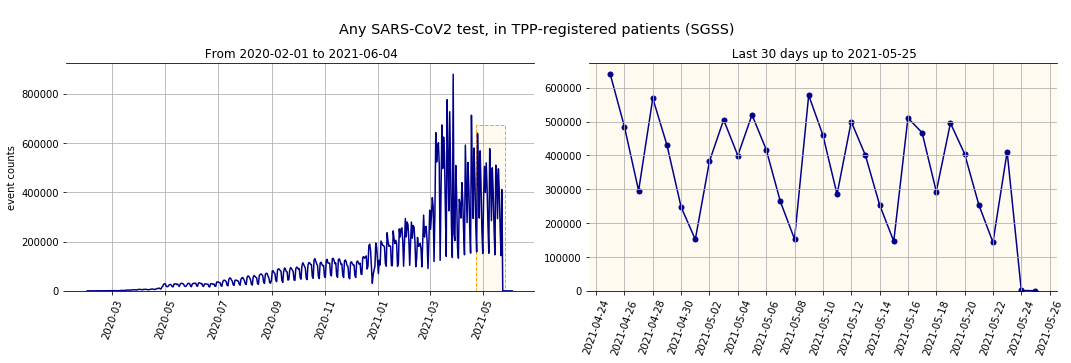

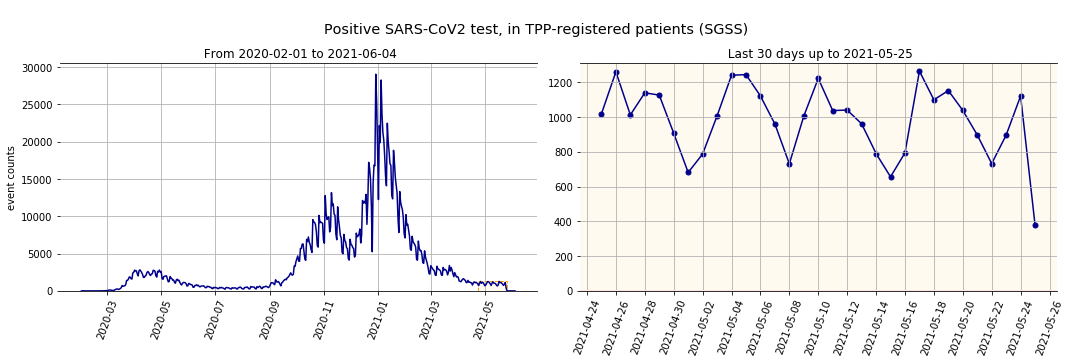

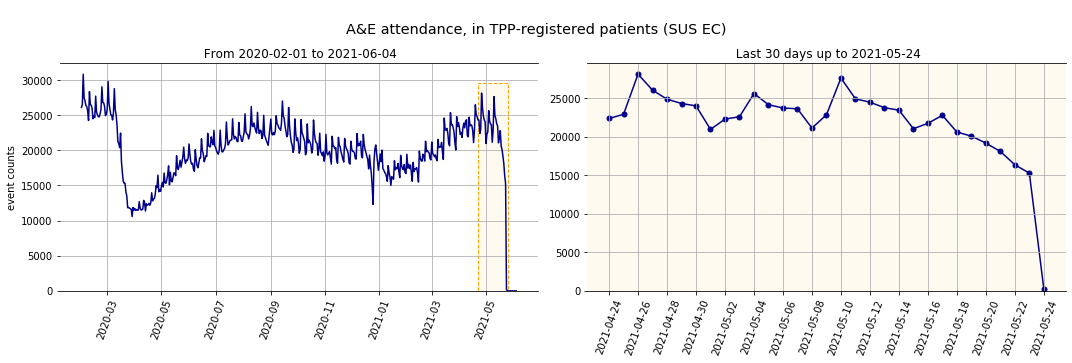

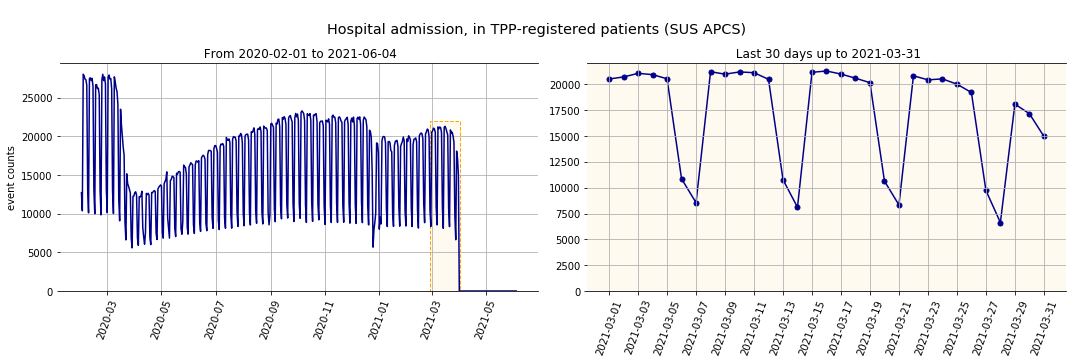

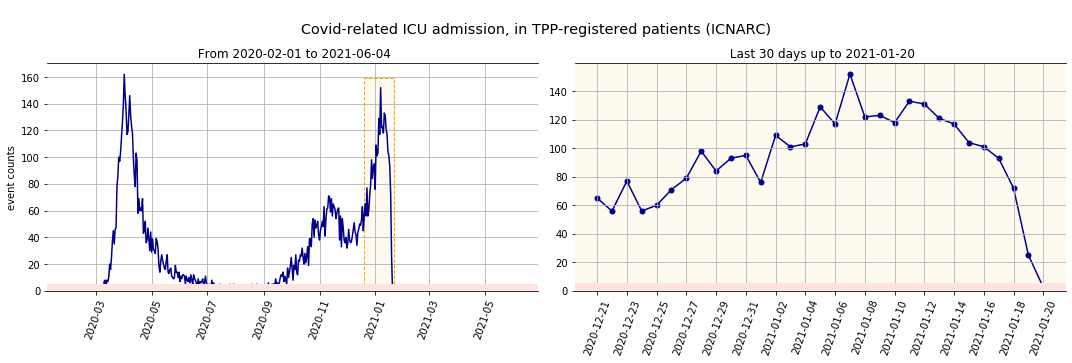

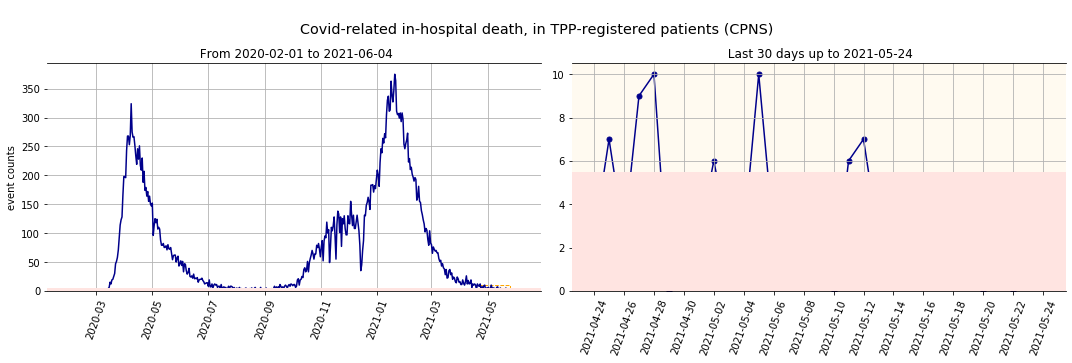

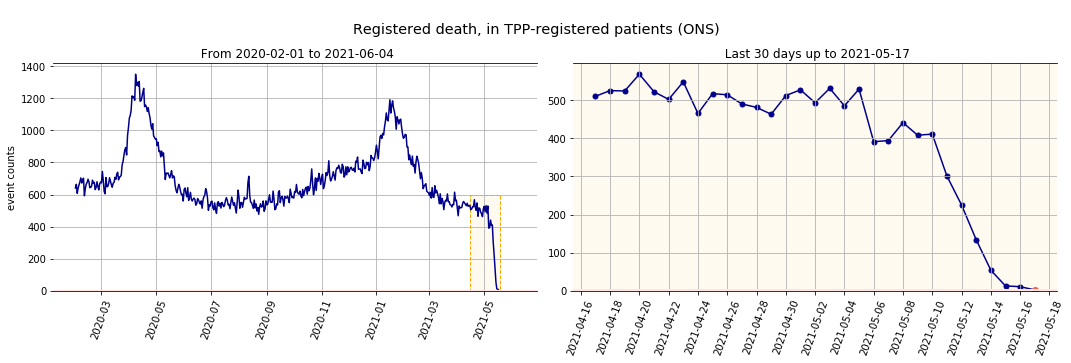

In [31]:
#plotcounts(date_range, CodedEvent_df['coded_event_date'], title="Any coded event in Primary Care, from SystmOne")
plotcounts(date_range, SGSS_df['specimen_date'], title="First-only SARS-CoV2 test, in TPP-registered patients (SGSS)")
plotcounts(date_range, SGSSpos_df['specimen_date'], title="First-only Positive SARS-CoV2 test, in TPP-registered patients (SGSS)")
plotcounts(date_range, SGSS_all_df['specimen_date'], title="Any SARS-CoV2 test, in TPP-registered patients (SGSS)")
plotcounts(date_range, SGSSpos_all_df['specimen_date'], title="Positive SARS-CoV2 test, in TPP-registered patients (SGSS)")
plotcounts(date_range, EC_df['ed_attendance_date'], title="A&E attendance, in TPP-registered patients (SUS EC)")
plotcounts(date_range, APCS_df['hosp_admission_date'], title="Hospital admission, in TPP-registered patients (SUS APCS)")
plotcounts(date_range, ICNARC_df['icu_admission_date'], title="Covid-related ICU admission, in TPP-registered patients (ICNARC)")
plotcounts(date_range, CPNS_df['cpns_death_date'], title="Covid-related in-hospital death, in TPP-registered patients (CPNS)")
plotcounts(date_range, ONS_df['ons_death_date'], title="Registered death, in TPP-registered patients (ONS)")

In [32]:
### number of visits per patient

def recurrentquery(table, id_table, date_table, from_date, head=5):
    query = (
    f"""
    SELECT a.*, b.patients_with_exactly_X_events 
    FROM (
        SELECT X, COUNT(X) AS patients_with_at_least_X_events 
        FROM
        (
            SELECT {id_table}, ROW_NUMBER() OVER(PARTITION BY {id_table} ORDER BY {id_table})  AS X
            FROM {table}
            WHERE {date_table} >= CONVERT(date, '{from_date}')
        ) AS a
        GROUP BY X
    ) AS a
    LEFT JOIN
    (
        SELECT X, COUNT(X) AS patients_with_exactly_X_events 
        FROM
        (
            select count(*) AS X
            FROM {table}
            WHERE {date_table} >= CONVERT(date, '{from_date}')
            GROUP BY {id_table}
        ) AS a
        GROUP BY X
    ) AS b
    ON a.X=b.X
    ORDER BY a.X
    """
    )
    
    display(Markdown(f"### Repeat events in {table}"))
    display(pd.read_sql(f"select count(*) as total_events from {table} where {date_table} >= CONVERT(date, '{from_date}')", cnxn))
    display(pd.read_sql(query, cnxn).fillna(0).astype(int).head(head).set_index("X"))
    print(" ")

## Recurrent events / repeat patient IDs
Some datasets may have multiple rows per patient, for instance if the patient was admitted to hospital more than once. 
Currently a study definition can return either the first event, the last event, or the count of events occurring during the period of interest. 
The tables below count recurrent events for each dataset from 1 February onwards, up to 5 events. 

`patients_with_at_least_1_events` is the number of unique patients in the dataset. 
This is the number of events that can be returned by a study variable that takes the first event or the last event, from 1 February onwards. 

In [33]:
with closing_connection(dbconn) as cnxn:
    recurrentquery("APCS", "Patient_ID", "Admission_Date", start_date_text, 5)
    recurrentquery("CPNS", "Patient_ID", "DateOfDeath", start_date_text, 5)
    recurrentquery("EC", "Patient_ID", "Arrival_Date", start_date_text, 5)
    recurrentquery("ICNARC", "Patient_ID", "IcuAdmissionDateTime", start_date_text, 5)
    #recurrentquery("SGSS", "Patient_ID", "Earliest_Specimen_Date", start_date_text, 5)
    recurrentquery("SGSS_Positive", "Patient_ID", "Earliest_Specimen_Date", start_date_text, 5)
    recurrentquery("SGSS_AllTests_Positive", "Patient_ID", "Specimen_Date", start_date_text, 5)
    recurrentquery("ONS_Deaths", "Patient_ID", "dod", start_date_text, 5)


### Repeat events in APCS

,total_events
0,7116131


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,3564300,2295717
2,1268583,678307
3,590276,254040
4,336236,117314
5,218922,61863


### Repeat events in CPNS

,total_events
0,35316


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,35316,35316


### Repeat events in EC

,total_events
0,9689864


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,5698023,3725461
2,1972562,1151037
3,821525,419266
4,402259,181536
5,220723,87508


### Repeat events in ICNARC

,total_events
0,11273


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,9468,8005
2,1463,1189
3,274,221
4,53,42
5,11,7


### Repeat events in SGSS_Positive

,total_events
0,1501249


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,1500919,1500589
2,330,330


### Repeat events in SGSS_AllTests_Positive

,total_events
0,1824040


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,1505595,1283012
2,222583,167986
3,54597,35197
4,19400,10890
5,8510,3694


### Repeat events in ONS_Deaths

,total_events
0,326190


,patients_with_at_least_X_events,patients_with_exactly_X_events
X,,
1,326190,326190
